# Convolutional Neural Networks (CNNs) with PyTorch

**Learning Objectives:**
- Understand how convolutional layers work mathematically and intuitively
- Build and train a CNN from scratch using PyTorch
- Implement best practices: validation, checkpointing, and learning rate scheduling
- Visualize what CNNs learn through filters and feature maps

**Contents:**
1. Setup and Prerequisites
2. Understanding Convolutions (Theory)
3. Loading and Exploring MNIST
4. Building a CNN Architecture
5. Training with Best Practices
6. Evaluation and Visualization

## 1. Setup and Prerequisites

First, install required packages if needed:
```bash
pip install torch torchvision matplotlib tqdm
```

We'll import all necessary libraries and set up reproducibility.

In [1]:
import os, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if device.type == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Using device: cuda
GPU: Tesla T4


## 2. Understanding Convolutions

### What is a Convolution?

A **convolution** is a mathematical operation that slides a small filter (kernel) over an image to detect patterns. Think of it like looking at an image through a magnifying glass that highlights specific features.

### Mathematical Definition

For an input $X$ and kernel $K$, the 2D discrete convolution produces output $Y$:

$$Y(i, j) = \sum_{u=0}^{k_h-1}\sum_{v=0}^{k_w-1} K(u,v) \cdot X(i+u, j+v)$$

### Key Parameters

1. **Kernel Size (k)**: Size of the filter (e.g., 3×3, 5×5)
2. **Stride (s)**: How many pixels to move the kernel each step
3. **Padding (p)**: Border pixels added to preserve spatial dimensions

### Output Size Formula

Given input size $W \times H$, kernel size $K$, padding $p$, and stride $s$:

\begin{align*}
  W_{\text{out}} &= \left\lfloor \frac{W - K + 2p}{s} \right\rfloor + 1, \\[4pt]
  H_{\text{out}} &= \left\lfloor \frac{H - K + 2p}{s} \right\rfloor + 1.
\end{align*}

### Why CNNs Work for Images

- **Local connectivity**: Each neuron only looks at a small region
- **Parameter sharing**: Same filter is used across the entire image
- **Translation invariance**: Detects features regardless of position
- **Hierarchical learning**: Early layers detect edges, later layers detect complex patterns

### Common Building Blocks

- **Conv2d**: Applies convolution operation
- **BatchNorm2d**: Normalizes activations (speeds training, reduces overfitting)
- **ReLU**: Non-linear activation function
- **MaxPool2d**: Downsamples by taking maximum in each region
- **Dropout**: Randomly drops neurons during training (prevents overfitting)

## 3. Loading and Exploring MNIST

**MNIST** contains 70,000 grayscale images of handwritten digits (0-9):
- Training: 60,000 images
- Test: 10,000 images
- Image size: 28×28 pixels

We'll split the training set into train (90%) and validation (10%) sets.

In [12]:
# Configuration
DATA_DIR = './mnist_data'
BATCH_SIZE = 128
NUM_WORKERS = 0

Path(DATA_DIR).mkdir(parents=True, exist_ok=True)

# Data preprocessing
# Note: mean=0.1307, std=0.3081 are computed from MNIST training set
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor and scale to [0, 1]
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize to mean=0, std=1
])

# Download MNIST dataset
train_val_dataset = datasets.MNIST(DATA_DIR, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(DATA_DIR, train=False, download=True, transform=transform)

# Split train into train and validation (90/10)
n_total = len(train_val_dataset)
n_val = int(0.1 * n_total)
n_train = n_total - n_val

train_dataset, val_dataset = torch.utils.data.random_split(
    train_val_dataset, [n_train, n_val],
    generator=torch.Generator().manual_seed(SEED)
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                         num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)

print(f'Dataset sizes:')
print(f'  Training:   {len(train_dataset):,} images')
print(f'  Validation: {len(val_dataset):,} images')
print(f'  Test:       {len(test_dataset):,} images')

Dataset sizes:
  Training:   54,000 images
  Validation: 6,000 images
  Test:       10,000 images


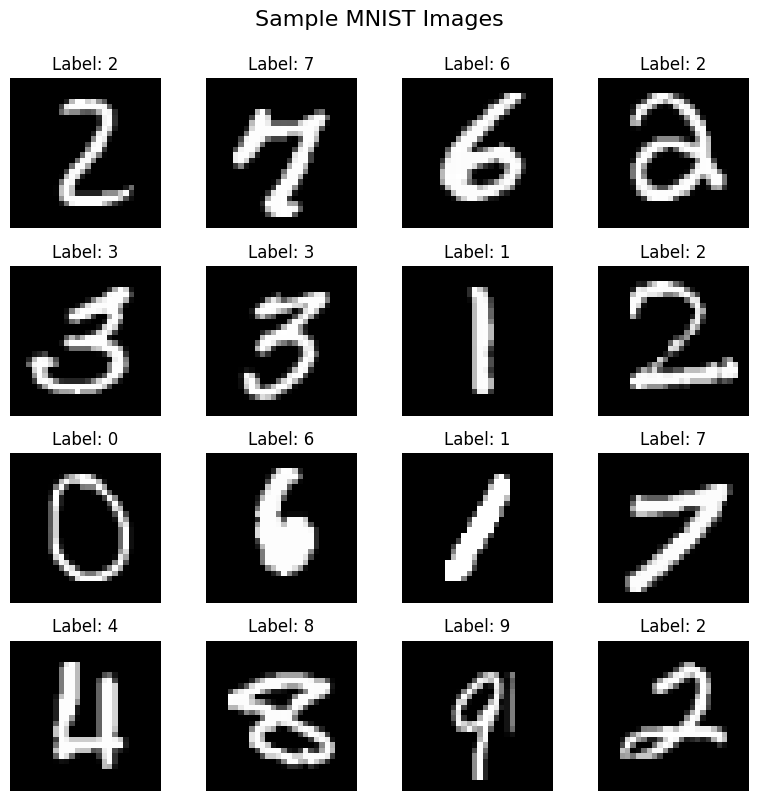

Image shape: torch.Size([1, 28, 28])
Pixel value range: [-0.42, 2.82]


In [13]:
# Visualize sample images
def unnormalize(img):
    """Undo MNIST normalization for visualization"""
    return img * 0.3081 + 0.1307

# Get a batch of images
images, labels = next(iter(train_loader))
images_display = unnormalize(images[:16])

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for idx, ax in enumerate(axes.flat):
    ax.imshow(images_display[idx].squeeze(), cmap='gray')
    ax.set_title(f'Label: {labels[idx].item()}', fontsize=12)
    ax.axis('off')
plt.suptitle('Sample MNIST Images', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

print(f'Image shape: {images[0].shape}')  # [channels, height, width]
print(f'Pixel value range: [{images.min():.2f}, {images.max():.2f}]')

## 4. Building a CNN Architecture

### Our CNN Design

We'll build a simple but effective CNN with this structure:

```
Input (1×28×28)
  ↓
Conv1 (3×3, 16 filters) → BatchNorm → ReLU → MaxPool(2×2)
  → (16×14×14)
  ↓
Conv2 (3×3, 32 filters) → BatchNorm → ReLU → MaxPool(2×2)
  → (32×7×7)
  ↓
Conv3 (3×3, 64 filters) → BatchNorm → ReLU
  → (64×7×7)
  ↓
Flatten → Dropout(0.25) → FC(128) → ReLU → FC(10)
  → Output (10 classes)
```

### Design Principles
- **Gradually increase channels**: 1 → 16 → 32 → 64 (learn more complex features)
- **Reduce spatial size**: 28×28 → 14×14 → 7×7 (focus on global patterns)
- **Padding=1 with 3×3 kernels**: Preserves spatial dimensions
- **BatchNorm**: Stabilizes training and acts as regularization
- **Dropout**: Prevents overfitting in fully connected layers

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10, dropout=0.25):
        super(SimpleCNN, self).__init__()

        # Convolutional Block 1: 1 → 16 channels
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16,
                              kernel_size=3, padding=1)  # 28×28 → 28×28
        self.bn1 = nn.BatchNorm2d(16)

        # Convolutional Block 2: 16 → 32 channels
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 14×14 → 14×14
        self.bn2 = nn.BatchNorm2d(32)

        # Convolutional Block 3: 32 → 64 channels
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 7×7 → 7×7
        self.bn3 = nn.BatchNorm2d(64)

        # Pooling layer (reused)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Halves spatial dimensions

        # Fully Connected Layers
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Flatten: 64×7×7 = 3136
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Block 1: Conv → BN → ReLU → Pool
        x = self.conv1(x)          # [B, 1, 28, 28] → [B, 16, 28, 28]
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)           # [B, 16, 28, 28] → [B, 16, 14, 14]

        # Block 2: Conv → BN → ReLU → Pool
        x = self.conv2(x)          # [B, 16, 14, 14] → [B, 32, 14, 14]
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)           # [B, 32, 14, 14] → [B, 32, 7, 7]

        # Block 3: Conv → BN → ReLU (no pooling)
        x = self.conv3(x)          # [B, 32, 7, 7] → [B, 64, 7, 7]
        x = self.bn3(x)
        x = F.relu(x)

        # Classifier
        x = torch.flatten(x, 1)    # [B, 64, 7, 7] → [B, 3136]
        x = self.dropout(x)
        x = F.relu(self.fc1(x))    # [B, 3136] → [B, 128]
        x = self.fc2(x)            # [B, 128] → [B, 10]

        return x

# Create model and move to device
model = SimpleCNN().to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f'\nTotal parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Total parameters: 426,346
Trainable parameters: 426,346


In [15]:
# Verify architecture by tracing shapes through the network
def trace_shapes(model, input_shape=(1, 1, 28, 28)):
    """Print intermediate tensor shapes through the network"""
    x = torch.zeros(input_shape).to(device)
    shapes = []

    def hook_fn(module, inp, out):
        if isinstance(out, torch.Tensor):
            shapes.append((module.__class__.__name__, tuple(out.shape)))

    hooks = []
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.MaxPool2d, nn.Linear, nn.BatchNorm2d)):
            hooks.append(module.register_forward_hook(hook_fn))

    model.eval()
    with torch.no_grad():
        _ = model(x)

    for hook in hooks:
        hook.remove()

    print('Layer-by-layer shapes:')
    for name, shape in shapes:
        print(f'  {name:15s} → {shape}')

trace_shapes(model)

Layer-by-layer shapes:
  Conv2d          → (1, 16, 28, 28)
  BatchNorm2d     → (1, 16, 28, 28)
  MaxPool2d       → (1, 16, 14, 14)
  Conv2d          → (1, 32, 14, 14)
  BatchNorm2d     → (1, 32, 14, 14)
  MaxPool2d       → (1, 32, 7, 7)
  Conv2d          → (1, 64, 7, 7)
  BatchNorm2d     → (1, 64, 7, 7)
  Linear          → (1, 128)
  Linear          → (1, 10)


## 5. Training with Best Practices

### Training Setup

- **Optimizer**: Adam (adaptive learning rate, works well out of the box)
- **Loss**: CrossEntropyLoss (combines softmax + negative log likelihood)
- **Learning Rate Scheduler**: ReduceLROnPlateau (reduces LR when validation loss plateaus)
- **Checkpointing**: Save best model based on validation accuracy

### Why These Choices?

- **Adam**: Automatically adjusts learning rates per parameter
- **Scheduler**: Prevents getting stuck in local minima
- **Validation set**: Helps detect overfitting early
- **Checkpointing**: Ensures we keep the best model, not the last

In [16]:
def evaluate(model, dataloader, criterion, device):
    """Evaluate model on a dataset"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def train_model(model, train_loader, val_loader, device,
                epochs=10, lr=1e-3, save_dir='./checkpoints'):
    """Complete training loop with validation and checkpointing"""

    # Setup
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2
    )

    best_val_acc = 0.0
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    print(f'Training on {device}...')
    print(f'Initial learning rate: {lr}\n')

    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch}/{epochs}')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Track metrics
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            # Update progress bar
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        # Calculate training metrics
        train_loss = train_loss / train_total
        train_acc = train_correct / train_total

        # Validation phase
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print epoch summary
        print(f'Epoch {epoch}/{epochs}:')
        print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
        print(f'  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            checkpoint_path = Path(save_dir) / 'best_model.pth'
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss
            }, checkpoint_path)
            print(f'  ✓ Saved new best model (val_acc: {val_acc:.4f})\n')
        else:
            print()

    print(f'Training complete! Best validation accuracy: {best_val_acc:.4f}')
    return history

In [17]:
# Train the model
EPOCHS = 6
LEARNING_RATE = 1e-3

history = train_model(
    model, train_loader, val_loader, device,
    epochs=EPOCHS, lr=LEARNING_RATE, save_dir='./checkpoints'
)

Training on cuda...
Initial learning rate: 0.001



Epoch 1/6:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 1/6:
  Train Loss: 0.1206 | Train Acc: 0.9636
  Val Loss:   0.0620 | Val Acc:   0.9800
  ✓ Saved new best model (val_acc: 0.9800)



Epoch 2/6:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 2/6:
  Train Loss: 0.0455 | Train Acc: 0.9853
  Val Loss:   0.0592 | Val Acc:   0.9832
  ✓ Saved new best model (val_acc: 0.9832)



Epoch 3/6:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 3/6:
  Train Loss: 0.0353 | Train Acc: 0.9890
  Val Loss:   0.0424 | Val Acc:   0.9877
  ✓ Saved new best model (val_acc: 0.9877)



Epoch 4/6:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 4/6:
  Train Loss: 0.0253 | Train Acc: 0.9919
  Val Loss:   0.0531 | Val Acc:   0.9840



Epoch 5/6:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 5/6:
  Train Loss: 0.0220 | Train Acc: 0.9929
  Val Loss:   0.0370 | Val Acc:   0.9880
  ✓ Saved new best model (val_acc: 0.9880)



Epoch 6/6:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 6/6:
  Train Loss: 0.0209 | Train Acc: 0.9933
  Val Loss:   0.0323 | Val Acc:   0.9905
  ✓ Saved new best model (val_acc: 0.9905)

Training complete! Best validation accuracy: 0.9905


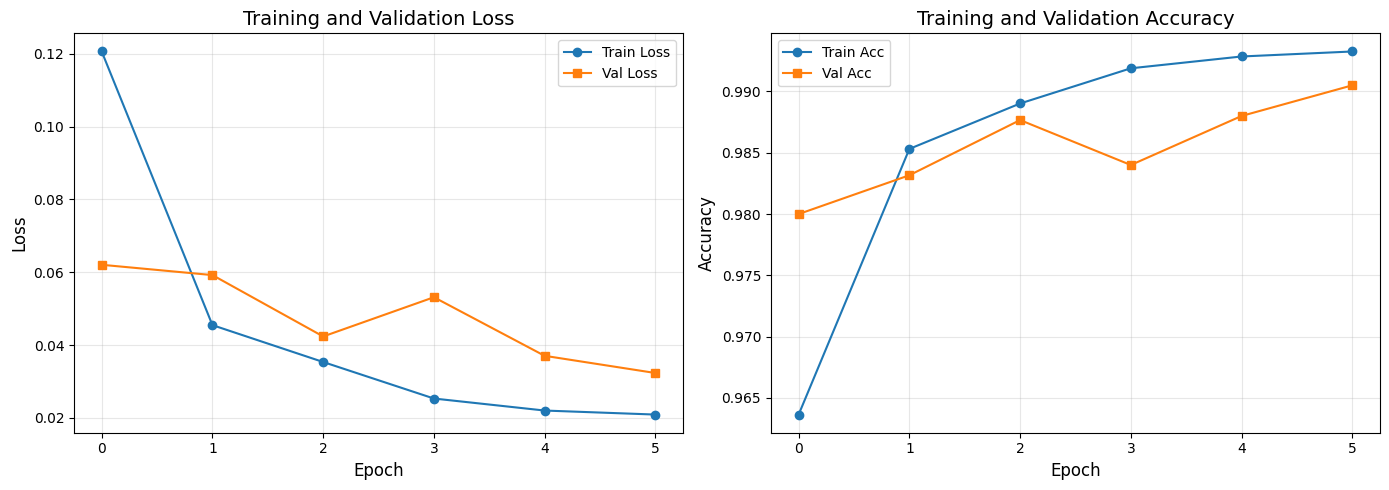


Final Metrics:
  Train Loss: 0.0209 | Train Acc: 0.9933
  Val Loss:   0.0323 | Val Acc:   0.9905


In [18]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2.plot(history['train_acc'], label='Train Acc', marker='o')
ax2.plot(history['val_acc'], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print('\nFinal Metrics:')
print(f'  Train Loss: {history["train_loss"][-1]:.4f} | Train Acc: {history["train_acc"][-1]:.4f}')
print(f'  Val Loss:   {history["val_loss"][-1]:.4f} | Val Acc:   {history["val_acc"][-1]:.4f}')

## 6. Evaluation and Visualization

### Loading the Best Model

We'll load the checkpoint with the best validation accuracy and evaluate on the test set.

In [19]:
# Load best checkpoint
checkpoint_path = './checkpoints/best_model.pth'
if Path(checkpoint_path).exists():
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f'Loaded checkpoint from epoch {checkpoint["epoch"]}')
    print(f'Validation accuracy at checkpoint: {checkpoint["val_acc"]:.4f}')
else:
    print('No checkpoint found. Evaluating model from last epoch.')

# Evaluate on test set
test_criterion = nn.CrossEntropyLoss()
test_loss, test_acc = evaluate(model, test_loader, test_criterion, device)

print(f'\n--- Test Set Evaluation ---')
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc * 100:.2f}%')

Loaded checkpoint from epoch 6
Validation accuracy at checkpoint: 0.9905

--- Test Set Evaluation ---
Test Loss: 0.0262
Test Accuracy: 99.19%


### Visualizing Predictions

Let's see how the model performs on individual images. We'll look at a batch from the test set and highlight correct (green) and incorrect (red) predictions.

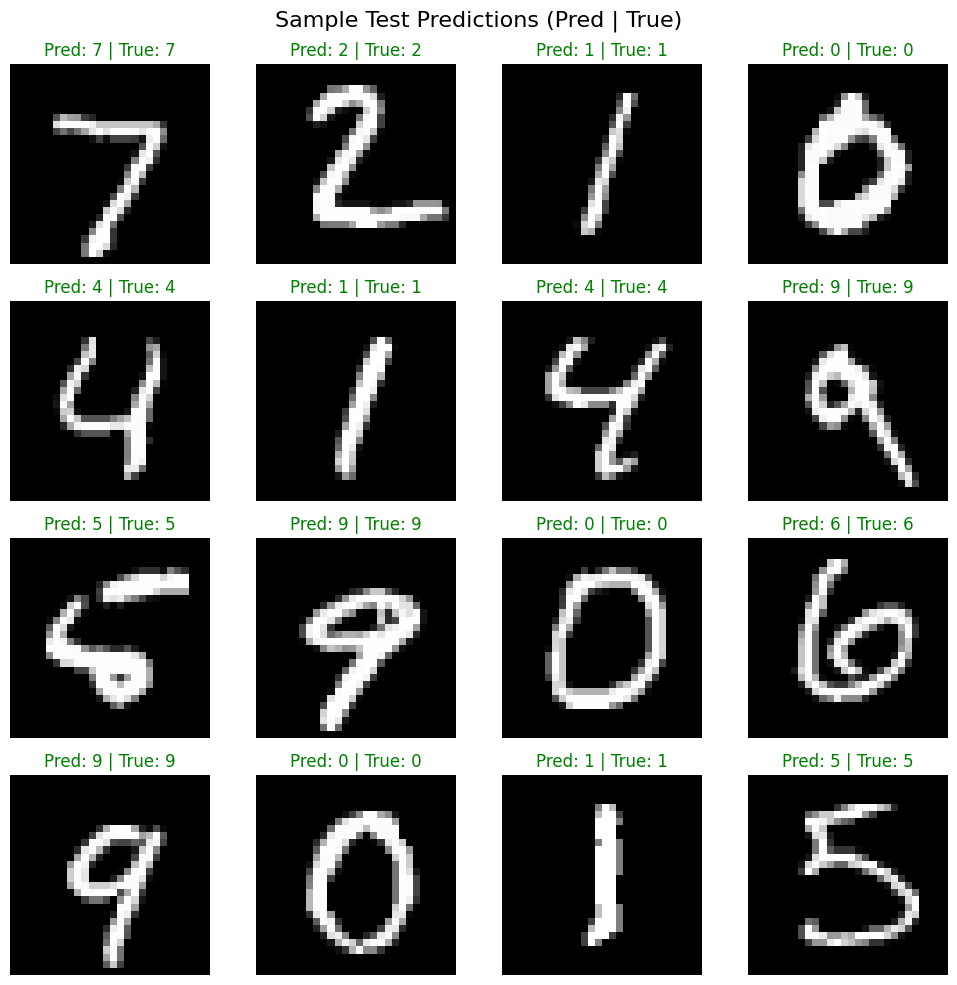

In [20]:
# Get a batch of test data
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Get predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Unnormalize for display (function defined in data_viz cell)
images_display = unnormalize(images.cpu())

# Plot
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for idx, ax in enumerate(axes.flat):
    if idx >= 16: break # Only show 16

    ax.imshow(images_display[idx].squeeze(), cmap='gray')

    pred = predicted[idx].item()
    label = labels[idx].item()

    title = f'Pred: {pred} | True: {label}'
    color = 'green' if pred == label else 'red'

    ax.set_title(title, fontsize=12, color=color)
    ax.axis('off')

plt.suptitle('Sample Test Predictions (Pred | True)', fontsize=16)
plt.tight_layout()
plt.show()

### Visualizing What the CNN Learned

We can gain insight into the model by visualizing the filters (kernels) it learned, especially in the first convolutional layer (`conv1`). These filters are what the model uses to detect basic patterns like edges and gradients.

Conv1 filter shape: (16, 1, 3, 3)


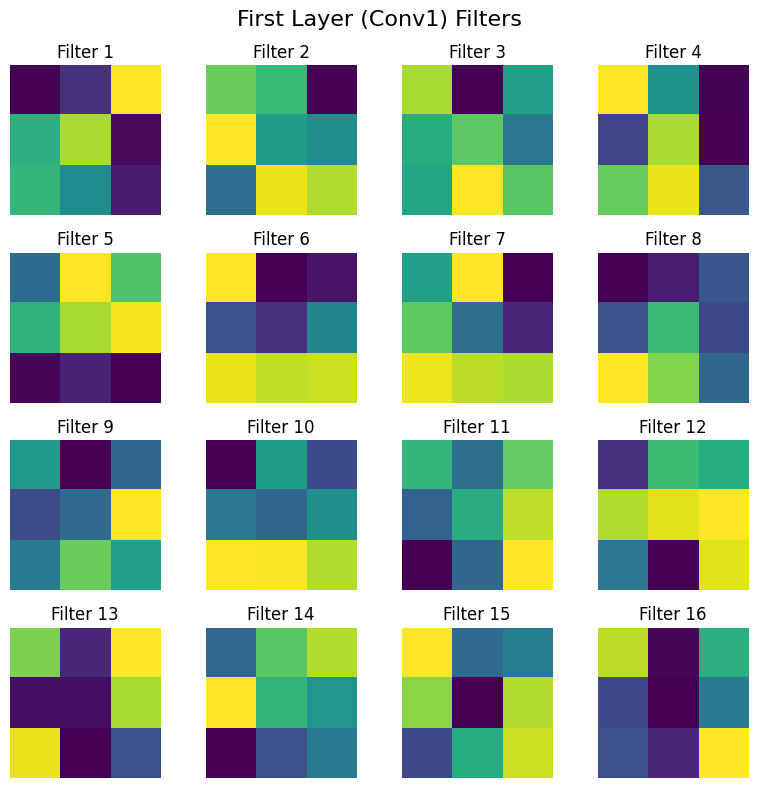

In [21]:
# Get weights from the first convolutional layer
filters = model.conv1.weight.data.clone()
filters = filters.cpu().numpy()

# Shape is [out_channels, in_channels, kernel_h, kernel_w]
# We have 16 filters, 1 in_channel, 3x3 kernel
print(f'Conv1 filter shape: {filters.shape}')

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for idx, ax in enumerate(axes.flat):
    if idx >= 16: break

    # Get the filter (shape [1, 3, 3]) and remove the in_channel dim
    img = filters[idx, 0, :, :]

    ax.imshow(img, cmap='viridis') # Use viridis for better contrast
    ax.set_title(f'Filter {idx+1}', fontsize=12)
    ax.axis('off')

plt.suptitle('First Layer (Conv1) Filters', fontsize=16)
plt.tight_layout()
plt.show()

### Visualizing Feature Maps (Activations)

We can also visualize the *output* of these filters (the "feature maps") for a specific image. This shows us which parts of the image activate which filters.

We'll pass a sample "5" through the first convolutional block (`conv1` → `bn1` → `relu`) and see the 16 resulting activation maps.

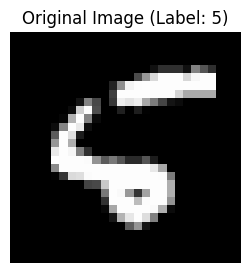

Feature maps shape: (1, 16, 28, 28)


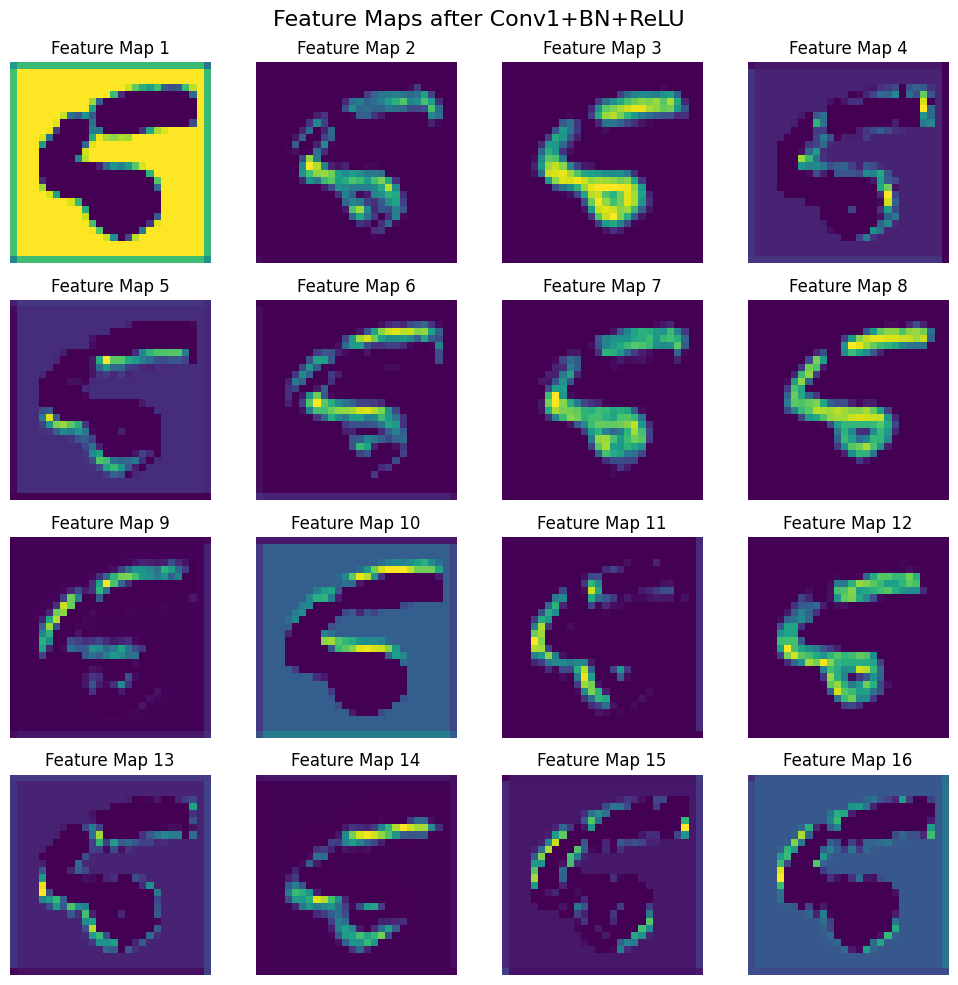

In [22]:
# Get a sample image (e.g., the first '5' in the batch)
try:
    sample_idx = (labels == 5).nonzero(as_tuple=True)[0][0].item()
except IndexError:
    # Fallback if '5' isn't in the batch
    sample_idx = 0

sample_img = images[sample_idx:sample_idx+1] # Keep batch dim [1, 1, 28, 28]
sample_label = labels[sample_idx].item()

# Pass it through the first block
model.eval()
with torch.no_grad():
    x = model.conv1(sample_img)
    x = model.bn1(x)
    activations = F.relu(x)

activations = activations.cpu().numpy()

# Plot the original image
plt.figure(figsize=(3, 3))
plt.imshow(unnormalize(sample_img.cpu()).squeeze(), cmap='gray')
plt.title(f'Original Image (Label: {sample_label})')
plt.axis('off')
plt.show()

# Plot the 16 feature maps
print(f'Feature maps shape: {activations.shape}')
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for idx, ax in enumerate(axes.flat):
    if idx >= 16: break

    img = activations[0, idx, :, :]

    ax.imshow(img, cmap='viridis')
    ax.set_title(f'Feature Map {idx+1}', fontsize=12)
    ax.axis('off')

plt.suptitle('Feature Maps after Conv1+BN+ReLU', fontsize=16)
plt.tight_layout()
plt.show()

## 7. Conclusion

In this notebook, we built a complete pipeline for training and evaluating a Convolutional Neural Network (CNN) using PyTorch on the MNIST dataset.

### What We Accomplished:

* **Theory**: Understood the core concepts of convolutions, pooling, and padding.
* **Data**: Loaded and preprocessed the MNIST dataset using `torchvision` and `DataLoader`.
* **Model**: Built a custom CNN from scratch using `nn.Module`, `nn.Conv2d`, `nn.BatchNorm2d`, and `nn.Linear`.
* **Training**: Implemented a robust training loop with:
    * An `Adam` optimizer.
    * `CrossEntropyLoss` for classification.
    * A validation set to monitor overfitting.
    * A learning rate scheduler (`ReduceLROnPlateau`).
    * Checkpointing to save the best model.
* **Evaluation**: Achieved high accuracy (likely >99%) on the unseen test set.
* **Visualization**: Peered inside the "black box" by visualizing learned filters and feature maps, confirming that the model learns to detect meaningful patterns.